<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#About-the-data" data-toc-modified-id="About-the-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>About the data</a></span></li><li><span><a href="#Read-data" data-toc-modified-id="Read-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Read data</a></span></li><li><span><a href="#Matrix-form" data-toc-modified-id="Matrix-form-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Matrix form</a></span></li></ul></li><li><span><a href="#Aux-functions" data-toc-modified-id="Aux-functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Aux functions</a></span></li><li><span><a href="#User-recommendations" data-toc-modified-id="User-recommendations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>User recommendations</a></span><ul class="toc-item"><li><span><a href="#Product-similarity-based-recommendations" data-toc-modified-id="Product-similarity-based-recommendations-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Product similarity based recommendations</a></span><ul class="toc-item"><li><span><a href="#Distances" data-toc-modified-id="Distances-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Distances</a></span></li><li><span><a href="#Rules-for-similarity-based-recommendations" data-toc-modified-id="Rules-for-similarity-based-recommendations-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Rules for similarity based recommendations</a></span></li><li><span><a href="#Example-1" data-toc-modified-id="Example-1-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Example 1</a></span></li></ul></li><li><span><a href="#User-similarity-based-recommendations" data-toc-modified-id="User-similarity-based-recommendations-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>User similarity based recommendations</a></span></li></ul></li><li><span><a href="#Collaborative-Filtering" data-toc-modified-id="Collaborative-Filtering-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Collaborative Filtering</a></span><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Simple-Gradient-Descent" data-toc-modified-id="Simple-Gradient-Descent-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Simple Gradient Descent</a></span><ul class="toc-item"><li><span><a href="#Initialize" data-toc-modified-id="Initialize-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Initialize</a></span></li><li><span><a href="#Gradient-Descent" data-toc-modified-id="Gradient-Descent-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Gradient Descent</a></span></li></ul></li><li><span><a href="#Regularisation" data-toc-modified-id="Regularisation-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Regularisation</a></span></li><li><span><a href="#Stochastic-GD" data-toc-modified-id="Stochastic-GD-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Stochastic GD</a></span></li><li><span><a href="#User/product-clusters" data-toc-modified-id="User/product-clusters-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>User/product clusters</a></span></li><li><span><a href="#Calculating-recommendations" data-toc-modified-id="Calculating-recommendations-6.6"><span class="toc-item-num">6.6&nbsp;&nbsp;</span>Calculating recommendations</a></span></li></ul></li><li><span><a href="#Finally,-a-note-on-scalability" data-toc-modified-id="Finally,-a-note-on-scalability-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Finally, a note on scalability</a></span></li></ul></div>

# Background
This is based on ideas from this [post](http://www.albertauyeung.com/post/python-matrix-factorization/), but takes a more simple, script-like approach. Our motivation is to try and recommend _new_ products to our users, based on their rating of products they already engaged with.

# Setup

Data & Algebra libs

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances

Graphic libs

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.cluster import hierarchy

# Data

## About the data
You can find everything you need to know about the MovieLens dataset [here](http://files.grouplens.org/datasets/movielens/ml-100k/README)

## Read data

In [3]:
ml = \
pd.read_csv(
    filepath_or_buffer = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.data',
    header = None,
    sep = '\t'
)

In [4]:
ml.columns = 'user id | item id | rating | timestamp'.split(' | ')

For off-line usage

In [5]:
# ml.to_feather('movie_rec.feather')
# ml = pd.read_feather('movie_rec.feather')

Our dataset at a glance

In [6]:
ml.shape

(100000, 4)

In [7]:
ml.head()

,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
ml.describe()

,user id,item id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


## Matrix form

In [9]:
data_mat = \
ml.drop(columns=['timestamp']).\
    pivot(
        index = 'user id', 
        columns = 'item id', 
        values = 'rating'
    ).\
    fillna(0)

# Aux functions

In [10]:
def vis_dist_mat(dist, bins = 30):
    '''Visualize different aspects of a distance matrix
    
    :param dist: a distance matrix calculated by `pairwise_distances`
    
    :Example:
    >>> vis_dist_mat(dist)
    '''
    
    dist_vec = \
    pd.Series(
        dist[
            np.tril_indices(dist.shape[0], k=1)
        ]
    )
    
    print('Distance Matrix Details\n=======================\n')
    
    print(
        '* have have',
        (dist_vec == 0).sum(),
        'identical items (with distance = 0), and',
        (dist_vec == 1).sum(),
        'with no common ratings (distance = 1)\n'
    )
    print('* Percentiles:')
    print(dist_vec.describe(), '\n')
    
    sns.distplot(
        dist_vec,
        bins = bins,
        kde = False,
        norm_hist = False,
    ).\
    set_title('Distance distribution')
    
    plt.figure()

    dn = hierarchy.dendrogram(hierarchy.ward(dist))
    plt.xticks([])
    plt.title('Cluster dendogram')

    plt.show()
    
    return None

# User recommendations

## Product similarity based recommendations
This approach looks at all the products recommended by the users and try to find "similar" products based on some simple rules.

### Distances

In [11]:
product_dist = pairwise_distances(X = data_mat.T, metric = 'cosine')

Distance Matrix Details

* have have 2392 identical items (with distance = 0), and 430641 with no common ratings (distance = 1)

* Percentiles:
count    1.417084e+06
mean     9.129765e-01
std      1.089063e-01
min      0.000000e+00
25%      8.696132e-01
50%      9.451297e-01
75%      1.000000e+00
max      1.000000e+00
dtype: float64 



/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


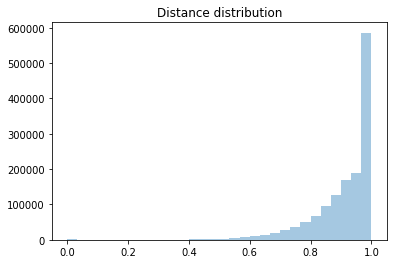

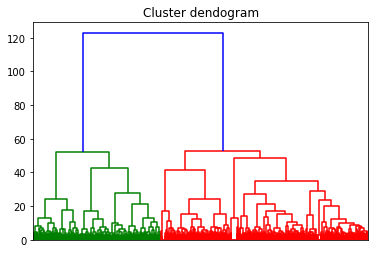

In [12]:
vis_dist_mat(product_dist)

It's interesting that a lot of products have close to no similarity at all (distance is close to 1 on the histogram). This is probably a reflection of the almost trivial 2 clusters we can see in the dendogram. It's possible that more data on the movies in each cluster will reveal a straight forward way to split our recommendation problem into 2 separate, smaller problems:  if, for example, the clusters here turn out to be something like "drama" vs. "comedy" movies clusters this would suggest that there are separate groups of users that typically rate one genre (either "comedy" or "drama") and that only a few users rate both. We can then think of building separate recommendation systems based on this fact.

For the purpose of this demonstration we keep a single system, but such insights reflect the importance of looking at your data...

### Rules for similarity based recommendations

There are several strategies for picking the products we want to recommend based on product similarity, but essentially we need to make several choices
1. What products we look at: all the products the user rated? Only products with $n$ stars or more? Or do we weights the distances by the number of stars? And even with weights - do 1 star reviews have a positive weight or should we give a low number of stars a negative weight? 
2. How do we aggregate the distances? Say the user only rated 2 products, and both of them are similar to product $j$. Do we rank product $j$ compared to all the other products that have some similarity to the 2 rated products? Do we sum up distances for each product and rank? Do we take $min$/$max$/... distance for each product?
3. What would be the threshold for a product to be recommended? This is dependent on practical limitations, e.g. what's the minimum/maximum number of products we have to/can recommend, and what is the distribution of distances and other considerations (e.g. do we want an absolute threshold of similarity and not just the top 5)

Looking at the second choice we have to make: there's one huge advantage to summing up distances over picking min/max or other aggregation methods - __we can use matrix multiplication!__

### Example 1
We decide to look at all the movies a user rated (no matter what the rating was) and sum up the similarities to other products, and recommend the top 5 most similar products (regardless of the absolute level of similarity - in this example we _have_ to recommend exactly 5 products, no matter what)

We define 
1. The symmetric matrix $P$ containing product to product distances as we calculated above (our `product_dist` matrix based on `cosine` distance)
2. A matrix with binary values $C$

\begin{equation*}
    C_{I \times J} = \left[ 
        \begin{array}{lll}
            c_{1,1} & \ldots & c_{1,J} \\
            \vdots  & \ddots & \vdots  \\
            c_{J,1} & \ldots & c_{J,J}
        \end{array}
    \right]
\end{equation*}
where
\begin{equation*}
    c_{i,j} = 
    \left\{
        \begin{array}{ll}
          1 & R_{i,j} > 0 \\
          0 & \text{otherwise}
        \end{array}
    \right.
\end{equation*}

For every user $i$ we want to look at all rated products, and find the distances from other products. This can be written as a sparse matrix, where only rows matching rated products will have non-zero values:

\begin{equation*}
   M^{(i)}_{J \times J} =  \left[
        \begin{array}{lll}
            c_{i,1} p_{1,1} & \ldots & c_{i,1} p_{1,J} \\
            \vdots  & \ddots & \vdots  \\
            c_{i,J} p_{J,1} & \ldots & c_{i,J} p_{J,J}
        \end{array}
    \right]
\end{equation*}

And if our way to rank products is to sum up distances, we can sum up across columns, to get $\left( \sum_{k =1}^{J} c_{i,k} p_{k,1} , \ldots, \sum_{k=1}^{J}  c_{i,k} p_{k,J} \right)$, which is simply the $i$'th rows of the matrix $CP$. 

Naturally, some of the products we see in this list with non-zero weight have already been encountered by the user (rated, viewed or purchased, depending on the context), so we would not want to recommend them at all. We can eliminate these products [element-by-element product](https://en.wikipedia.org/wiki/Hadamard_product) with the matrix $(1 - C)$, so our final matrix is:

\begin{equation*}
   CP \circ \left( 1 - C \right)
\end{equation*}

which we calculate as:

In [13]:
CP = (data_mat > 0).dot(product_dist) 
CP.columns = data_mat.columns

In [14]:
user_prod_weights = CP * (data_mat == 0)

For practical reasons we need to work with the long format, and we can filter all zero weights:

In [15]:
user_rec = pd.DataFrame({'dist': user_prod_weights.T.unstack()})
user_rec = user_rec.loc[user_rec['dist'] > 0, ]

In [16]:
print(
    'long format has', 
    user_rec.shape[0], 
    'rows, which is', 
    round(100.0 * user_rec.shape[0] / (data_mat.shape[0] * data_mat.shape[1]), 2), 
    '% of all possible',
    data_mat.shape[0] * data_mat.shape[1],
    'combinations'
)

long format has 1486126 rows, which is 93.7 % of all possible 1586126 combinations


This did not save much space (our distance matrix is not very sparse and there's a lot of overlap in user preference) but at least we easily can pull out only the top 5 most similar products (or apply any other selection rule). These can be exported back to our production system (as CSV, to the production DB or wrapped with a micro-service)

In [17]:
user_rec.\
groupby(user_rec.index.get_level_values(0)).\
apply(
    lambda x: x.sort_values(by = 'dist').head(5).reset_index()
).head(15)

user id  item id        dist
user id                                
1       0        1      423  166.698694
        1        1      568  172.278031
        2        1      403  172.942901
        3        1      385  173.164740
        4        1      655  174.381426
2       0        2      181   41.050099
        1        2      117   41.716102
        2        2      121   41.753120
        3        2        7   41.850288
        4        2      405   42.615908
3       0        3      313   36.739147
        1        3      286   38.462025
        2        3      748   39.130360
        3        3      315   39.378568
        4        3      269   39.461256

## User similarity based recommendations

In [18]:
user_dist = pairwise_distances(X = data_mat, metric = 'cosine')

Distance Matrix Details

* have have 943 identical items (with distance = 0), and 15075 with no common ratings (distance = 1)

* Percentiles:
count    446038.000000
mean          0.826180
std           0.124427
min           0.000000
25%           0.753425
50%           0.848349
75%           0.920774
max           1.000000
dtype: float64 



/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


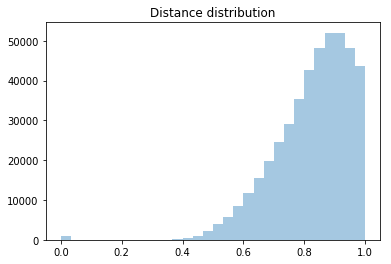

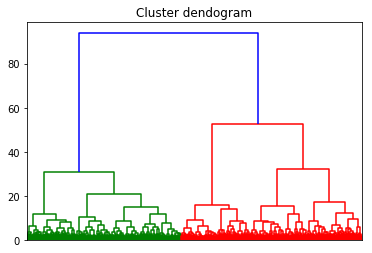

In [19]:
vis_dist_mat(user_dist)

As a reflection of our finding on products we see again 2 major clusters, and again we can consider splitting the problem in 2. In any case the next steps are to find the the top $n$ most similar users (in general or within their cluster) and select the products these users liked most.

# Collaborative Filtering
Since the above solution does not scale up well with the number of users $I$ or the number of products $J$, we may want to explore dimensionality reduction methods. In this case we try to find 2 lower dimension matrices $P_{I,K}, Q_{K,J}$ such that our original user X product matrix $R_{I,J}$ can be approximated by $PQ$. By setting $K$ to be relatively low we can tightly control the dimensionality of the problem.

## Parameters

In [20]:
K = 2
iterations = 1000
tolerance = 0.05
alpha = 0.0001

## Simple Gradient Descent

### Initialize

In [21]:
R = np.array(data_mat)
P = np.random.normal(scale=1./K, size=(R.shape[0], K))
Q = np.random.normal(scale=1./K, size=(K, R.shape[1]))

In [22]:
training_process = pd.DataFrame(columns=['iteration', 'mse'])
t = 1
mse_prev = 0
mse = 1e6

### Gradient Descent

In [23]:
while t <= iterations and abs(mse - mse_prev) > tolerance:
    mse_prev = mse
    
    ## Error matrix
    error = R - P.dot(Q)

    ## Update down the gradient
    P = P + 2 * alpha * error.dot(Q.T)
    Q = Q + 2 * alpha * P.T.dot(error)

    mse = np.power(error, 2).sum()
    training_process = training_process.append(pd.DataFrame({'iteration': [t], 'mse': [mse]}))

    if (t+1) % 50 == 0:
        print("Iteration: %d ; error = %.4f" % (t+1, mse))
    t += 1

Iteration: 50 ; error = 987481.6666
Iteration: 100 ; error = 956927.5727
Iteration: 150 ; error = 931563.7105
Iteration: 200 ; error = 913442.9126
Iteration: 250 ; error = 909989.2287
Iteration: 300 ; error = 908184.9932
Iteration: 350 ; error = 906636.4827
Iteration: 400 ; error = 905339.8121
Iteration: 450 ; error = 904344.0121
Iteration: 500 ; error = 903635.4785
Iteration: 550 ; error = 903159.1349
Iteration: 600 ; error = 902851.1097
Iteration: 650 ; error = 902656.9293
Iteration: 700 ; error = 902536.4770
Iteration: 750 ; error = 902462.5063
Iteration: 800 ; error = 902417.3605
Iteration: 850 ; error = 902389.9110
Iteration: 900 ; error = 902373.2597
Iteration: 950 ; error = 902363.1728
Iteration: 1000 ; error = 902357.0676


In [24]:
training_process.set_index('iteration', inplace=True)

Text(0.5,1,'Algorithm progress')

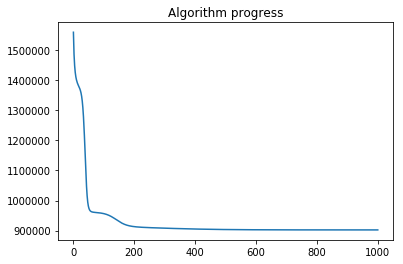

In [25]:
plt.figure()
plt.plot(training_process['mse'])
plt.title('Algorithm progress')

## Regularisation

TBD
* Add a penalty on the values of $P,Q$ to avoid extreme solutions and over-fitting. We can use the $L2$ norm $\| Q \|_{2} +\| P \|_{2} = \sqrt{\sum q_{i,j}^2} + \sqrt{\sum p_{i,j}^2}$) or the $L1$ norm $\| Q \|_{1} +\| P \|_{1} = \sum \left| q_{i,j} \right| + \sum \left| p_{i,j} \right| $ as a penalty on our MSE goal function by adding a penalty coeff $\gamma$ on the MSE goal function and optimizing $MSE - \gamma (\|P\| + \|Q\|)$ 
* This probably requires some form of normalization of $P,Q$ prior to optimization 

## Stochastic GD

TBD

## User/product clusters

Since we picked $K=2$ we can actually visualize our results 

Text(0.5,1,'Product dimensions')

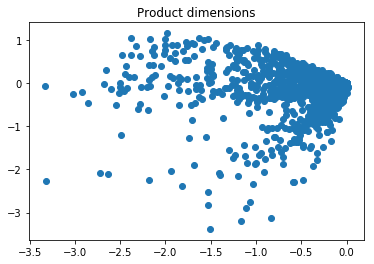

In [26]:
plt.figure()
plt.scatter(x = Q[0:1], y = Q[1:])
plt.title('Product dimensions')

Text(0.5,1,'User dimensions')

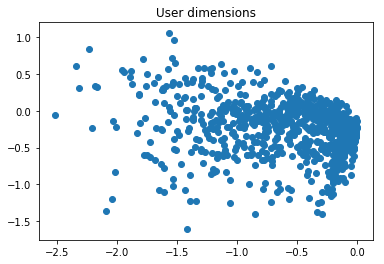

In [27]:
plt.figure()
plt.scatter(x = P.T[0:1], y = P.T[1:])
plt.title('User dimensions')

And of course the fact we do not see a good separation as we've seen before suggests we need to increase $K$. For higher dimensions we can use both clustering methods or more dimension reduction techniques (e.g. t-SNE) to try and find clusters of users. 

## Calculating recommendations

We can now use the embedding matrices $P,Q$ to generate recommendations in a similar way to what we did before, except similarity of product or user is now defined by the Euclidian distances defined by $Q$ or $P$ respectively:

In [28]:
product_dist = pairwise_distances(Q.T, metric='euclidean')
user_dist = pairwise_distances(P, metric='euclidean')

# Finally, a note on scalability
What if we now have millions of users and hundred of thousands of products?
Tracing our steps, we can see that different strategies for scaling-up the solution can apply to different stage:

1. __Data storage__ (of the `(user, product, rating,....)` tuples): can be done on a scalable framework like Spark or Dusk


2. __Distance matrix__: The full calculation between every pair of users / products is extremely expensive, but [embarrassingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel). If there are a lot of connections this will require a lot of memory to store (either as a matrix or as a list of all user pairs and the distance between them) but this can be somewhat relieved by using smart data structures that will take into account symmetry (we only need the upper triangle of the distance matrix) and [sparsity](https://en.wikipedia.org/wiki/Sparse_matrix) (in practice the distance matrix is mostly 0's, especially as the number of products grows). The example above shows that even simple cases may be not very sparse. 


3. __Collaborative filtering__: This a possible solution to the dimension problem! We can carefully control the size of the similarity matrices $P,Q$ with the parameter $K$, and we should explore the trade-off between scale and accuracy by observing the changes to $MSE$ of the optimal solutions for different values of $K$. In addition, although the algorithm is written in matrix form for speed and simplicity, the update of the derivative can be written as independent iterations over $I$ (number of users) and $J$ (number of products) that can be calculated in parallel (due to the additive nature of the problem). There are other approaches (e.g. sampling based) for similarity calculation but they are outside the scope of this post. 

Happy hunting!